<a href="https://colab.research.google.com/github/YasineNifa/DeepLearning-Using-TF/blob/master/nlp_in_tensorflow_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recurrent Neural Networks (RNN's)
For our next series of modelling experiments we're going to be using a special kind of neural network called a Recurrent Neural Network (RNN).

The premise of an RNN is simple: use information from the past to help you with the future (this is where the term recurrent comes from). In other words, take an input (X) and compute an output (y) based on all previous inputs.

This concept is especially helpful when dealing with sequences such as passages of natural language text (such as our Tweets).

For example, when you read this sentence, you take into context the previous words when deciphering the meaning of the current word dog.

See what happened there?

I put the word "dog" at the end which is a valid word but it doesn't make sense in the context of the rest of the sentence.

When an RNN looks at a sequence of text (already in numerical form), the patterns it learns are continually updated based on the order of the sequence.

For a simple example, take two sentences:

* Massive earthquake last week, no?
* No massive earthquake last week.

Both contain exactly the same words but have different meaning. The order of the words determines the meaning (one could argue punctuation marks also dictate the meaning but for simplicity sake, let's stay focused on the words).

Recurrent neural networks can be used for a number of sequence-based problems:

* One to one: one input, one output, such as image classification.
* One to many: one input, many outputs, such as image captioning (image input, a sequence of text as caption output).
* Many to one: many inputs, one outputs, such as text classification (classifying a Tweet as real diaster or not real diaster).
* Many to many: many inputs, many outputs, such as machine translation (translating English to Spanish) or speech to text (audio wave as input, text as output).
When you come across RNN's in the wild, you'll most likely come across variants of the following:

* Long short-term memory cells (LSTMs).
* Gated recurrent units (GRUs).
* Bidirectional RNN's (passes forward and backward along a sequence, left to right and right to left).

Going into the details of each these is beyond the scope of this notebook (we're going to focus on using them instead), the main thing you should know for now is that they've proven very effective at modelling sequences.

For a deeper understanding of what's happening behind the scenes of the code we're about to write, I'd recommend the following resources:

> 📖 Resources:
* MIT Deep Learning Lecture on Recurrent Neural Networks - explains the background of recurrent neural networks and introduces LSTMs.
* The Unreasonable Effectiveness of Recurrent Neural Networks by Andrej Karpathy - demonstrates the power of RNN's with examples generating various sequences.
* Understanding LSTMs by Chris Olah - an in-depth (and technical) look at the mechanics of the LSTM cell, possibly the most popular RNN building block.

### Model 2 : LSTM


In [ ]:
# Download data 
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

--2021-04-15 13:23:25--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.15.128, 173.194.76.128, 66.102.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.15.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.009s  

2021-04-15 13:23:25 (67.0 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [ ]:
import zipfile
def unzip_data(filename):
  zip_ref = zipfile.ZipFile(filename)
  zip_ref.extractall()
  zip_ref.close()

unzip_data("nlp_getting_started.zip")

In [ ]:
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
train_df_shuffled = train_df.sample(frac=1,random_state=42)
train_df_shuffled.head(5)

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
from sklearn.model_selection import train_test_split
train_data, val_data, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                  train_df_shuffled['target'].to_numpy(),
                                                                  test_size = 0.1,
                                                                  random_state = 42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode = "int",
                                    output_sequence_length=max_length)

text_vectorizer.adapt(train_data)

In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = max_vocab_length,
                             output_dim = 128,# size of embedding vector
                             embeddings_initializer = "uniform",
                             input_length = max_length)

In [ ]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
outputs = layers.Dense(1,activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs,outputs,name = "model_2_LSTM")

> 🔑 Note: Reading the documentation for the TensorFlow LSTM layer, you'll find a plethora of parameters. Many of these have been tuned to make sure they compute as fast as possible. The main ones you'll be looking to adjust are units (number of hidden units) and return_sequences (set this to True when stacking LSTM or other recurrent layers).

Now we've got our LSTM model built, let's compile it using "binary_crossentropy" loss and the Adam optimizer.

In [ ]:
model_2.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
SAVE_DIR = "model_logs"
model_2.fit(train_data,train_labels,epochs=5,
            validation_data = (val_data,val_labels),
            callbacks = [create_tensorboard_callback(SAVE_DIR,"LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20210415-132334
Epoch 1/5
215/215 [==============================] - 36s 26ms/step - loss: 0.5785 - accuracy: 0.6821 - val_loss: 0.4551 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3061 - accuracy: 0.8780 - val_loss: 0.4668 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 5s 21ms/step - loss: 0.2085 - accuracy: 0.9262 - val_loss: 0.5118 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 5s 21ms/step - loss: 0.1483 - accuracy: 0.9489 - val_loss: 0.6295 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 5s 21ms/step - loss: 0.1005 - accuracy: 0.9654 - val_loss: 0.7537 - val_accuracy: 0.7677


In [ ]:
model_2_pred_probs = model_2.predict(val_data)
model_2_pred_probs[:10]

array([[0.03278309],
       [0.7701728 ],
       [0.9975758 ],
       [0.03116872],
       [0.00884641],
       [0.9987531 ],
       [0.93596745],
       [0.99893993],
       [0.99885297],
       [0.08126581]], dtype=float32)

In [ ]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 76.77165354330708,
 'f1': 0.7656749923220023,
 'precision': 0.7691343474319641,
 'recall': 0.7677165354330708}

## Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

> for better explanation : 
* Gated Recurrent Unit Wikipedia page
* Understanding GRU networks by Simeon Kostadinov

In [ ]:
from tensorflow.keras import layers
input = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(input)
x = embedding(x)
x = layers.GRU(64)(x) #return_sequences=True comme LSTM()
outputs = layers.Dense(1,activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs=input, outputs= outputs, name ="model_3_GRU")


In [ ]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________



Notice the difference in number of trainable parameters between model_2 (LSTM) and model_3 (GRU). The difference comes from the LSTM cell having more trainable parameters than the GRU cell.

In [ ]:
model_3_history = model_3.fit(train_data,
            train_labels,
            epochs=5,
            validation_data=(val_data,val_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR,"GRU")])

Saving TensorBoard log files to: model_logs/GRU/20210415-132430
Epoch 1/5
215/215 [==============================] - 8s 26ms/step - loss: 0.3416 - accuracy: 0.8408 - val_loss: 0.7335 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 4s 21ms/step - loss: 0.0939 - accuracy: 0.9666 - val_loss: 0.7621 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0746 - accuracy: 0.9711 - val_loss: 0.7909 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 4s 21ms/step - loss: 0.0644 - accuracy: 0.9765 - val_loss: 1.0122 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 5s 21ms/step - loss: 0.0517 - accuracy: 0.9781 - val_loss: 0.9902 - val_accuracy: 0.7638


Time to make some predictions

In [ ]:
model_3_preds_probs = model_3.predict(val_data)
model_3_preds_probs[:10]

array([[6.2643820e-03],
       [6.3674587e-01],
       [9.9985552e-01],
       [1.0645943e-01],
       [6.3347851e-04],
       [9.9981278e-01],
       [9.8658806e-01],
       [9.9988687e-01],
       [9.9978119e-01],
       [1.4961442e-01]], dtype=float32)

Again we get an array of prediction probabilities back which we can convert to prediction classes by rounding them.

In [ ]:
model_3_preds = tf.squeeze(tf.round(model_3_preds_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

Now we've got predicted classes, let's evaluate them against the ground truth labels.

In [ ]:
model_3_results = calculate_results(y_true=val_labels, y_pred=model_3_preds)
model_3_results

{'accuracy': 76.37795275590551,
 'f1': 0.7621412379223811,
 'precision': 0.764383846466808,
 'recall': 0.7637795275590551}

Finally we can compare our GRU model's results to our baseline.

In [ ]:

# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

#compare_baseline_to_new_results(baseline_results=baseline_results, new_model_results=model_1_results)

In [ ]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab),words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

And now let's get our embedding layer's weights (these are the numerical representations of each word).


In [ ]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model


# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.summary()

# Fit the model
model_1_history = model_1.fit(train_data, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_data, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________
Saving TensorBoard log files to: model_logs/simple_dense_model/20210415-132458
Epoch 1/5
215/215 [===========

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_data, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
baseline_score = model_0.score(val_data, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_data)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights.shape

(10000, 128)

### Model 4: Bidirectonal RNN model
A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.

Intuitively, this can be thought of as if you were reading a sentence for the first time in the normal fashion (left to right) but for some reason it didn't make sense so you traverse back through the words and go back over them again (right to left).

In practice, many sequence models often see and improvement in performance when using bidirectional RNN's.

However, this improvement in performance often comes at the cost of longer training times and increased model parameters (since the model goes left to right and right to left, the number of trainable parameters doubles).

In [ ]:
from tensorflow.keras import layers
input = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(input)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_4 = tf.keras.Model(input,outputs,name="model_4_Bidirectional")

> 🔑 Note: You can use the Bidirectional wrapper on any RNN cell in TensorFlow. For example, layers.Bidirectional(layers.GRU(64)) creates a bidirectional GRU cell.

In [ ]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


Notice the increased number of trainable parameters in model_4 (bidirectional LSTM) compared to model_2 (regular LSTM). This is due to the bidirectionality we added to our RNN.

In [ ]:
model_4_history =model_4.fit(train_data,
            train_labels,
            epochs=5,
            validation_data=(val_data,val_labels),
            callbacks = [create_tensorboard_callback(SAVE_DIR,"bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20210415-132520
Epoch 1/5
215/215 [==============================] - 11s 34ms/step - loss: 0.2191 - accuracy: 0.9289 - val_loss: 0.8347 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0792 - accuracy: 0.9697 - val_loss: 0.9824 - val_accuracy: 0.7625
Epoch 3/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0571 - accuracy: 0.9744 - val_loss: 1.1421 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0417 - accuracy: 0.9805 - val_loss: 1.2000 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0433 - accuracy: 0.9821 - val_loss: 1.1701 - val_accuracy: 0.7664


In [ ]:
model_4_pred_probs = model_4.predict(val_data)
model_4_pred_probs[:10]

array([[2.7252911e-03],
       [7.9630148e-01],
       [9.9989784e-01],
       [7.6241687e-02],
       [2.0245909e-04],
       [9.9979705e-01],
       [9.9869859e-01],
       [9.9993610e-01],
       [9.9986064e-01],
       [1.8171802e-01]], dtype=float32)

In [ ]:
model_4_pred = tf.squeeze(tf.round(model_4_pred_probs))
model_4_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_4_results = calculate_results(val_labels, model_4_pred)
model_4_results

{'accuracy': 76.64041994750657,
 'f1': 0.7651213533864446,
 'precision': 0.7665895370389821,
 'recall': 0.7664041994750657}

In [ ]:
compare_baseline_to_new_results(baseline_results, model_4_results)


Baseline accuracy: 79.27, New accuracy: 76.64, Difference: -2.62
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.03
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


### Convolutional Neural Networks for Text
You might've used convolutional neural networks (CNNs) for images before but they can also be used for sequences.

The main difference between using CNNs for images and sequences is the shape of the data. Images come in 2-dimensions (height x width) where as sequences are often 1-dimensional (a string of text).

So to use CNNs with sequences, we use a 1-dimensional convolution instead of a 2-dimensional convolution.

> tensorflow.keras.layers.Conv1D() layer followed by a tensorflow.

> keras.layers.GlobablMaxPool1D() layer.

> 📖 Resource: The intuition here is explained succinctly in the paper Understanding Convolutional Neural Networks for Text Classification, where they state that CNNs classify text through the following steps:
* 1-dimensional convolving filters are used as ngram detectors, each filter specializing in a closely-related family of ngrams (an ngram is a collection of n-words, for example, an ngram of 5 might result in "hello, my name is Daniel").
* 2-Max-pooling over time extracts the relevant ngrams for making a decision.
* 3-The rest of the network classifies the text based on this information.

###Model 5: Conv1D


In [ ]:
from tensorflow.keras import layers
input = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(input)
x = embedding(x)
x = layers.Conv1D(kernel_size=5,filters=32,activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_5 = tf.keras.Model(input,outputs,name="model_5_Conv1D")
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_5.summary() 

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 11, 32)            20512     
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,300,545
Trainable params: 1,300,545
Non-trainable params: 0
__________________________________________

In [ ]:
model_5.fit(train_data,
            train_labels,
            epochs=5,
            validation_data=(val_data,val_labels),
            callbacks = [create_tensorboard_callback(SAVE_DIR,"Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20210415-132553
Epoch 1/5
215/215 [==============================] - 6s 21ms/step - loss: 0.2149 - accuracy: 0.9357 - val_loss: 0.7628 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0815 - accuracy: 0.9701 - val_loss: 0.8899 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0672 - accuracy: 0.9748 - val_loss: 0.9843 - val_accuracy: 0.7546
Epoch 4/5
215/215 [==============================] - 4s 16ms/step - loss: 0.0496 - accuracy: 0.9823 - val_loss: 1.0680 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0438 - accuracy: 0.9812 - val_loss: 1.1016 - val_accuracy: 0.7625


In [ ]:
model_5_pred_probs = model_5.predict(val_data)
model_5_pred_probs[:10]

array([[1.4801797e-01],
       [8.8093263e-01],
       [9.9982578e-01],
       [4.1849084e-02],
       [1.4853042e-06],
       [9.9455124e-01],
       [9.5227301e-01],
       [9.9982268e-01],
       [9.9999487e-01],
       [6.0398501e-01]], dtype=float32)

In [ ]:
model_5_pred = tf.squeeze(tf.round(model_5_pred_probs))
model_5_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
model_5_results = calculate_results(val_labels,model_5_pred)
model_5_results

{'accuracy': 76.24671916010499,
 'f1': 0.7613223680610013,
 'precision': 0.762420601385426,
 'recall': 0.7624671916010499}

In [ ]:
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 76.25, Difference: -3.02
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.02


## Using Pretrained Embeddings (transfer learning for NLP)
 a common practice is to leverage pretrained embeddings through transfer learning. This is one of the main benefits of using deep models: being able to take what one (often larger) model has learned (often on a large amount of data) and adjust it for our own use case.

 For our next model, instead of using our own embedding layer, we're going to replace it with a pretrained embedding layer.

 More specifically, we're going to be using the Universal Sentence Encoder from TensorFlow Hub (a great resource containing a plethora of pretrained model resources for a variety of tasks)

 > 🔑 Note: There are many different pretrained text embedding options on TensorFlow Hub, however, some require different levels of text preprocessing than others. Best to experiment with a few and see which best suits your use case.

### Model 6: TensorFlow Hub Pretrained Sentence Encoder

The main difference between the embedding layer we created and the Universal Sentence Encoder is that rather than create a word-level embedding, the Universal Sentence Encoder, as you might've guessed, creates a whole sentence-level embedding.

Our embedding layer also outputs an a 128 dimensional vector for each word, where as, the Universal Sentence Encoder outputs a 512 dimensional vector for each sentence.

>🔑 Note: An encoder is the name for a model which converts raw data such as text into a numerical representation (feature vector), a decoder converts the numerical representation to a desired output.

In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")# load Universal Sentence Encoder


In [ ]:
embed_samples = embed(["When you call the universal sentence encoder on a sentence, it turns it into numbers."])
embed_samples

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[ 3.59669067e-02, -8.57946947e-02, -1.15274256e-02,
         5.25985099e-03, -1.85217224e-02, -5.04201241e-02,
        -3.61694023e-02,  5.34677971e-03,  4.80591543e-02,
         4.69074100e-02, -3.72332968e-02, -1.14954282e-02,
         4.35241386e-02,  7.05099404e-02,  7.09376112e-02,
        -8.18042979e-02,  8.71717278e-03, -4.65412140e-02,
        -2.24577747e-02,  4.68687378e-02,  2.02256767e-03,
         3.09906770e-02,  2.04356033e-02,  6.39216900e-02,
        -7.64108673e-02,  8.42118040e-02, -4.57603857e-02,
        -1.06166315e-03, -2.05941461e-02,  1.24110701e-02,
         5.72753996e-02,  3.81562077e-02, -2.74211671e-02,
        -3.54349939e-03, -9.83258486e-02, -1.24485819e-02,
         3.86562794e-02,  5.03195561e-02, -2.36250665e-02,
         3.21847177e-03,  3.22520956e-02,  7.38093210e-03,
         4.47310172e-02, -4.12236759e-03,  1.15160560e-02,
         2.83772852e-02,  6.01372391e-04, -5.90335354e-02,
      

In [ ]:
embed_samples.shape

TensorShape([1, 512])

In [ ]:
len(embed_samples.numpy())

1

Passing our sentences to the Universal Sentence Encoder (USE) encodes them from strings to 512 dimensional vectors, which make no sense to us but hopefully make sense to our machine learning models.

Speaking of models, let's build one with the USE as our embedding layer.

We can convert the TensorFlow Hub USE module into a Keras layer using the hub.KerasLayer class.

In [ ]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [ ]:
model_6 = tf.keras.Sequential([
                               sentence_encoder_layer,# take in sentences and then encode them into an embedding
                               layers.Dense(64, activation="relu"),
                               layers.Dense(1,activation="sigmoid")
                              ], name = "model_6_USE")
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


Notice the number of paramters in the USE layer, these are the pretrained weights its learned on various text sources (Wikipedia, web news, web question-answer forums, etc, see the Universal Sentence Encoder paper for more).

The trainable parameters are only in our output layers, in other words, we're keeping the USE weights frozen and using it as a feature-extractor. We could fine-tune these weights by setting trainable=True when creating the hub.KerasLayer instance.

Now we've got a feature extractor model ready, let's train it and track its results to TensorBoard using our create_tensorboard_callback() function.

In [ ]:
# input = layers.Input(shape=(1,), dtype="string")
# x = embed([input])
# x = layers.Dense(64, activation="relu")(x)
# output = layers.Dense(1,activation="sigmoid")(x)
# model_6_bis = tf.keras.Model(input,output,name="model_6_bis")

In [ ]:
model_6_history = model_6.fit(train_data,
                              train_labels,
                              epochs=5,
                              validation_data=(val_data,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20210415-132644
Epoch 1/5
215/215 [==============================] - 10s 30ms/step - loss: 0.5807 - accuracy: 0.7409 - val_loss: 0.4464 - val_accuracy: 0.7979
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4117 - accuracy: 0.8199 - val_loss: 0.4420 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4025 - accuracy: 0.8238 - val_loss: 0.4369 - val_accuracy: 0.8071
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3926 - accuracy: 0.8301 - val_loss: 0.4280 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3844 - accuracy: 0.8299 - val_loss: 0.4232 - val_accuracy: 0.8176


In [ ]:
model_6_pred_probs = model_6.predict(val_data)
model_6_pred_probs[:10]

array([[0.18174729],
       [0.77857256],
       [0.9916797 ],
       [0.21978101],
       [0.76260537],
       [0.7815589 ],
       [0.9872158 ],
       [0.98148936],
       [0.94806737],
       [0.08829779]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.75853018372703,
 'f1': 0.8164548892316194,
 'precision': 0.8188543841314186,
 'recall': 0.8175853018372703}

In [ ]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.76, Difference: 2.49
Baseline precision: 0.81, New precision: 0.82, Difference: 0.01
Baseline recall: 0.79, New recall: 0.82, Difference: 0.02
Baseline f1: 0.79, New f1: 0.82, Difference: 0.03


### Model 6: TensorFlow Hub Pretrained Sentence Encoder (retrained)

In [ ]:
 # We can use this encoding layer in place of our text_vectorizer and embedding layer

sentence_encoder_layer_bis = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=True, # retrain keep the pretrained weights (we'll create a feature extractor)
                                        name="USE-bis")

In [ ]:
model_6_bis = tf.keras.Sequential([
                               sentence_encoder_layer_bis,# take in sentences and then encode them into an embedding
                               layers.Dense(64, activation="relu"),
                               layers.Dense(1,activation="sigmoid")
                              ], name = "model_6_USE_bis")
model_6_bis.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_6_bis.summary()

Model: "model_6_USE_bis"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE-bis (KerasLayer)         (None, 512)               256797824 
_________________________________________________________________
dense_7 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 256,830,721
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_6_history_bis = model_6_bis.fit(train_data,
                              train_labels,
                              epochs=5,
                              validation_data=(val_data,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"tf_hub_sentence_encoder_bis")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_bis/20210415-131832
Epoch 1/5
215/215 [==============================] - 515s 2s/step - loss: 0.5166 - accuracy: 0.7520 - val_loss: 0.4139 - val_accuracy: 0.8255
Epoch 2/5
215/215 [==============================] - 502s 2s/step - loss: 0.2359 - accuracy: 0.9121 - val_loss: 0.4606 - val_accuracy: 0.8202
Epoch 3/5
215/215 [==============================] - 502s 2s/step - loss: 0.0734 - accuracy: 0.9770 - val_loss: 0.5767 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 503s 2s/step - loss: 0.0369 - accuracy: 0.9871 - val_loss: 0.7650 - val_accuracy: 0.7467
Epoch 5/5
215/215 [==============================] - 503s 2s/step - loss: 0.0233 - accuracy: 0.9887 - val_loss: 0.6693 - val_accuracy: 0.8045


In [ ]:
model_6_pred_probs_bis = model_6_bis.predict(val_data)
model_6_pred_probs_bis[:10]

In [ ]:
model_6_results_bis = calculate_results(val_labels, model_6_preds_bis)
model_6_results_bis

In [ ]:
model_6_preds_bis = tf.squeeze(tf.round(model_6_pred_probs_bis))
model_6_preds_bis[:10]

In [ ]:
compare_baseline_to_new_results(baseline_results, model_6_results_bis)

One of the benefits of using transfer learning methods, such as, the pretrained embeddings within the USE is the ability to get great results on a small amount of data (the USE paper even mentions this in the abstract).

In [ ]:
#model_7 = tf.keras.models.clone_model(model_6)

### Comparing the performance of each of our models

In [ ]:
import pandas as pd
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
lstm,76.771654,0.769134,0.767717,0.765675
gru,76.377953,0.764384,0.763780,0.762141
bidirectional,76.640420,0.766590,0.766404,0.765121
conv1d,76.246719,0.762421,0.762467,0.761322
tf_hub_sentence_encoder,81.758530,0.818854,0.817585,0.816455


In [ ]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
lstm,0.767717,0.769134,0.767717,0.765675
gru,0.763780,0.764384,0.763780,0.762141
bidirectional,0.766404,0.766590,0.766404,0.765121
conv1d,0.762467,0.762421,0.762467,0.761322
tf_hub_sentence_encoder,0.817585,0.818854,0.817585,0.816455


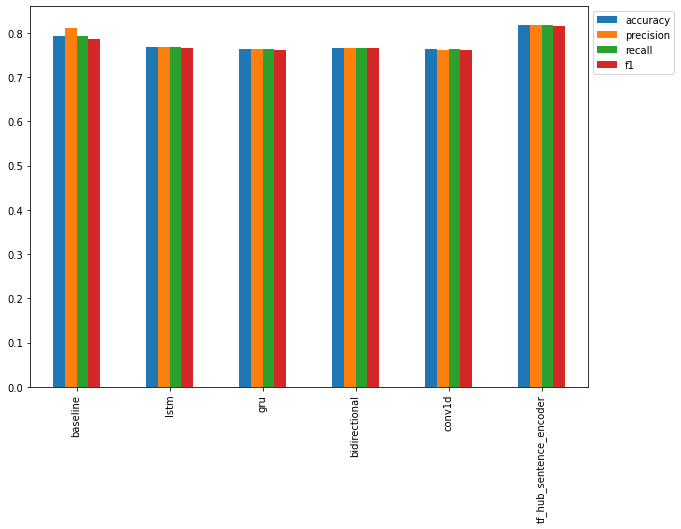

In [ ]:
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

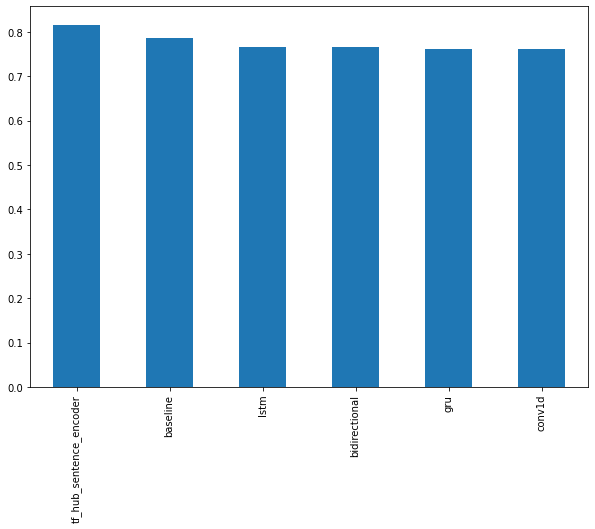

In [ ]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [ ]:

# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./model_logs \
  --name "NLP modelling experiments" \
  --description "A series of different NLP modellings experiments with various models" \
  --one_shot # exits the uploader when upload has finished

### Combining our models (model ensembling/stacking)

Many production systems use an ensemble (multiple different models combined) of models to make a prediction.

The idea behind model stacking is that if several uncorrelated models agree on a prediction, then the prediction must be more robust than a prediction made by a singular model.

The keyword in the sentence above is uncorrelated, which is another way of saying, different types of models. For example, in our case, we might combine our baseline, our bidirectional model and our TensorFlow Hub USE model.

Although these models are all trained on the same data, they all have a different way of finding patterns.

If we were to use three similarly trained models, such as three LSTM models, the predictions they output will likely be very similar.

Think of it as trying to decide where to eat with your friends. If you all have similar tastes, you'll probably all pick the same restaurant. But if you've all got different tastes and still end up picking the same restaurant, the restaurant must be good.

Since we're working with a classification problem, there are a few of ways we can combine our models:

Averaging - Take the output prediction probabilities of each model for each sample, combine them and then average them.
Majority vote (mode) - Make class predictions with each of your models on all samples, the predicted class is the one in majority. For example, if three different models predict [1, 0, 1] respectively, the majority class is 1, therefore, that would be the predicted label.
Model stacking - Take the outputs of each of your chosen models and use them as inputs to another model.

> 📖 Resource: The above methods for model stacking/ensembling were adapted from Chapter 6 of the Machine Learning Engineering Book by Andriy Burkov. If you're looking to enter the field of machine learning engineering, not only building models but production-scale machine learning systems, I'd highly recommend reading it in its entirety.

We're going to combine our baseline model (model_0), LSTM model (model_2) and our USE model trained on the full training data (model_6) by averaging the combined prediction probabilities of each.